In [1]:
%pwd

'/home/hearth/ML/course/deeplearning1/nbs'

In [2]:
import os, sys
import numpy as np
import importlib
import utils; importlib.reload(utils)
from utils import *

%matplotlib inline

Using cuDNN version 7003 on context None
Mapped name None to device cuda0: GeForce GTX 1080 Ti (0000:01:00.0)
Using Theano backend.


In [3]:
#reference to imp directories
current_dir = os.getcwd()
LESSON_HOME_DIR = current_dir
DATA_HOME_DIR = current_dir+'/data/dogscats/'

In [4]:
path=DATA_HOME_DIR

## Resnet
Resnet is unique in that it is made of Resnet blocks where, in each block there is conv layers and maxpooling in in succession but in the end of a resnet block, there is an addition with an identity matrix. 

In [5]:
import resnet50; importlib.reload(resnet50)
from resnet50 import Resnet50

In [6]:
#Setting include top to false means only include convolutional layers and
#the additional fully connected blocks will be ignored. 
rn0 = Resnet50(include_top=False).model

/opt/anaconda/lib/python3.6/site-packages/keras/layers/core.py:629: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))
/home/hearth/ML/course/deeplearning1/nbs/resnet50.py:61: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (7, 7), name="conv1", strides=(2, 2))`
  x = Conv2D(64, 7, 7, subsample=(2, 2), name='conv1')(x)  # Keras2


here I go again


In [7]:
rn0.output_shape[1:]

(2048, 7, 7)

In [8]:
%cd $DATA_HOME_DIR

#Set path to sample/ path if desired
models_path = DATA_HOME_DIR + 'models/resnet/'
test_path = DATA_HOME_DIR + '/test/' #Using all the test data
results_path=DATA_HOME_DIR + '/results/'
train_path=path + '/train/'
valid_path=path + '/valid/'

/home/hearth/ML/course/deeplearning1/nbs/data/dogscats


In [9]:
batch_size = 64
batches = get_batches(train_path, batch_size=batch_size)
val_batches = get_batches(valid_path, batch_size=batch_size)
test_batches = get_batches(test_path, batch_size=batch_size)

shuffle is  False
Found 22998 images belonging to 2 classes.
shuffle is  False
Found 2000 images belonging to 2 classes.
shuffle is  False
Found 12500 images belonging to 1 classes.


In [10]:
(val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames) = get_classes(path)

shuffle is  False
Found 22998 images belonging to 2 classes.
shuffle is  False
Found 2000 images belonging to 2 classes.
shuffle is  False
Found 12500 images belonging to 1 classes.


### Precompute features

#### If RAM>32

In [ ]:
val_features = rn0.predict_generator(val_batches, np.ceil(val_batches.samples/batch_size))

In [ ]:
trn_features = rn0.predict_generator(batches, np.ceil(batches.samples/batch_size))

In [37]:
trn_labels[0]

array([ 1.,  0.])

In [ ]:
trn_features= load_array(models_path + 'trn_rn0_conv.bc')
val_features = load_array(models_path +'val_rn0_conv.bc')

#### If RAM<32

In [11]:
fname = models_path+'trn_rn0_conv.dat'
for i in range(batches.n // batch_size+1):
    conv_feat = rn0.predict_on_batch(batches.next()[0])
    if not i:
        c = bcolz.carray(conv_feat, rootdir=fname, mode='a')
    else:
        c.append(conv_feat)
    c.shape
c.flush()

In [19]:
fname = models_path+'val_rn0_conv.dat'
for i in range(val_batches.n // batch_size+1):
    conv_val_feat = rn0.predict_on_batch(val_batches.next()[0])
    if not i:
        c = bcolz.carray(conv_val_feat, rootdir=fname, mode='a')
    else:
        c.append(conv_val_feat)
c.flush()

In [14]:
fname = models_path+'val_rn0_conv_y.dat'
save_array(fname, val_labels)
fname = models_path+'trn_rn0_conv_y.dat'
save_array(fname, trn_labels)

In [11]:
X=bcolz.open(models_path+'trn_rn0_conv.dat', mode='r')
y= bcolz.open(models_path+'trn_rn0_conv_y.dat', mode='r')

In [12]:
valX=bcolz.open(models_path+'val_rn0_conv.dat', mode='r')
valy= bcolz.open(models_path+'val_rn0_conv_y.dat', mode='r')

In [13]:
trn_batches=BcolzArrayIterator(X,y, batch_size=batch_size, shuffle=True)
val_batches=BcolzArrayIterator(valX,valy, batch_size=batch_size, shuffle=True)

## Fully connected layer

In [14]:
trn_batches.N

22998

In [15]:
def get_fc_layers(p):
    return [
        BatchNormalization(axis=1, input_shape=rn0.output_shape[1:]),
        Flatten(),
        Dropout(p),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(p/2),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(2, activation='softmax')
    ]

In [22]:
fc_model = Sequential(get_fc_layers(0.8))
fc_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
fc_model.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
fc_model.fit_generator(trn_batches, epochs=5, steps_per_epoch=np.ceil(trn_batches.N/batch_size), validation_data=val_batches, 
                     validation_steps=int(np.ceil(val_batches.N/batch_size)))

Epoch 1/5
360/360 [==============================] - 10s - loss: 0.0185 - acc: 0.9931 - val_loss: 0.0675 - val_acc: 0.9840
Epoch 2/5
360/360 [==============================] - 9s - loss: 0.0175 - acc: 0.9946 - val_loss: 0.0458 - val_acc: 0.9905
Epoch 3/5
360/360 [==============================] - 9s - loss: 0.0110 - acc: 0.9963 - val_loss: 0.0505 - val_acc: 0.9840
Epoch 4/5
360/360 [==============================] - 10s - loss: 0.0129 - acc: 0.9956 - val_loss: 0.0500 - val_acc: 0.9900
Epoch 5/5
360/360 [==============================] - 9s - loss: 0.0074 - acc: 0.9973 - val_loss: 0.0646 - val_acc: 0.9875


In [20]:
fc_model.fit(trn_features, trn_labels, epochs=50, batch_size=batch_size, validation_data=(val_features, val_labels))

NameError: name 'trn_features' is not defined

## Making predictions on individual samples

In [56]:
import matplotlib.image as mpimg

img = mpimg.imread(path+'/15.jpg')
print(img.shape)

(499, 377, 3)


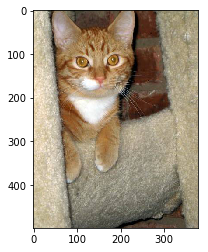

In [57]:
from matplotlib import pyplot as plt
plt.imshow(img, interpolation='nearest')
plt.show()

In [58]:
import scipy.misc
img = scipy.misc.imresize(img, (224, 224))

In [59]:
img = img.reshape([1, 3, 224, 224], order='C')

In [60]:
conv_feat = rn0.predict(img)

In [61]:
np.set_printoptions(suppress=True)
fc_model.predict(conv_feat, batch_size=None, verbose=0)

array([[ 0.6691,  0.3309]], dtype=float32)


## Resnet's Global Average Pooling Layer


In [30]:
 def get_ap_layers(p):
        return [
            GlobalAveragePooling2D(input_shape=rn0.output_shape[1:]),
            Dropout(p),
            Dense(2, activation='softmax')
        ]

In [31]:
model = Sequential(get_ap_layers(0.2))

In [32]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit_generator(trn_batches, epochs=2, steps_per_epoch=np.ceil(trn_batches.N/batch_size), validation_data=val_batches, 
                     validation_steps=int(np.ceil(val_batches.N/batch_size)))